In [12]:
import cv2 as cv
import numpy as np
import sys
import math

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (13.0, 13.0)

path = "./data/slova/s2.jpg"

def implt(img, cmp=None, t=''):
    plt.imshow(img, cmap=cmp)
    plt.title(t)
    plt.show()

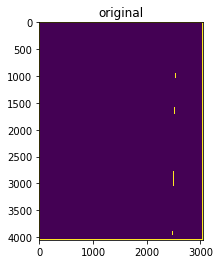

In [2]:
src = cv.imread(path)

cdst = src.copy()
img_gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)    
img_blured = cv.medianBlur(img_gray, 101)
edges = cv.Canny(img_blured, 10, 50, apertureSize=3)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3, 3))
dilated = cv.dilate(edges, kernel)
dst = dilated

cdst = cv.cvtColor(dst.copy(), cv.COLOR_GRAY2BGR)

dst = cv.copyMakeBorder(dst, 10, 10, 10, 10, cv.BORDER_CONSTANT, value=[255, 255, 255])

#dst = cv.Canny(src, 50, 200)
#cdst = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)


implt(dst, t='original')

--------------------
RESULTS:
Average vertical angle deviation: 1.6849313752069477
rho: 50.0 theta: 89.00000133828577
rho: 3999.0 theta: 90.99999684048139
rho: 144.0 theta: 1.9999999845072665
rho: 2490.0 theta: 0.0
OOO YEAH: [[202, 107], [2430, 66], [64, 3939], [2430, 3983]]
height: 3917.0
width: 2366.409093964947


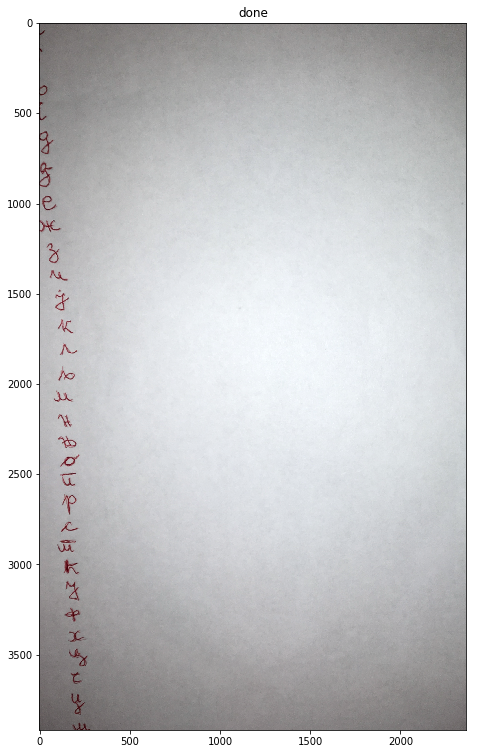

In [13]:
img_clone = src.copy()

lines = cv.HoughLines(dst, 1, math.pi/180.0, 250, np.array([]),0,0)
if lines is not None:
    a,b,c = lines.shape
    for i in range(a):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        #print('rho: ' + str(rho) + ' theta: ' + str(theta*180/math.pi))
        a = math.cos(theta)
        b = math.sin(theta)
        x0, y0 = a*rho, b*rho
        pt1 = ( int(x0+6000*(-b)), int(y0+6000*(a)) )
        pt2 = ( int(x0-6000*(-b)), int(y0-6000*(a)) )
        cv.line(img_clone, pt1, pt2, (0, 0, 255), 3, cv.LINE_AA)
        
print("--------------------")
print("RESULTS:")

average_v_angle_dev = find_average_vertical_angle_deviation(lines)
print("Average vertical angle deviation: " + str(average_v_angle_dev))

results = [find_top(lines, dst, average_v_angle_dev),\
           find_bottom(lines, dst, average_v_angle_dev),\
           find_left(lines, dst, average_v_angle_dev),\
           find_right(lines, dst, average_v_angle_dev)]

for result in results:
    rho = result[0]
    theta = result[1]
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0, y0 = a*rho, b*rho
    pt1 = ( int(x0+6000*(-b)), int(y0+6000*(a)) )
    pt2 = ( int(x0-6000*(-b)), int(y0-6000*(a)) )
    cv.line(img_clone, pt1, pt2, (255, 0, 0), 15, cv.LINE_AA)
    
    print('rho: ' + str(rho) + ' theta: ' + str(theta*180/math.pi))
    
t = get_corners(results)
print("OOO YEAH: " + str(t))
for tt in t:
    cv.circle(img_clone, tuple(tt), 40, (0,255,0), -1)
    
#implt(img_clone, t='done')

final = persp_transform(src.copy(), np.array(t))
implt(final, t='done')

In [10]:
def persp_transform(img, s):
    """ Transform perspective from start points to target points """
    # Euclidean distance - calculate maximum height and width
    
    s_points = np.array([s[0], s[2], s[3], s[1]])
    
    height = max(np.linalg.norm(s_points[0] - s_points[1]),
                 np.linalg.norm(s_points[2] - s_points[3]))
    width = max(np.linalg.norm(s_points[1] - s_points[2]),
                 np.linalg.norm(s_points[3] - s_points[0]))
    
    print('height: ' + str(height))
    print('width: ' + str(width))
    
    # Create target points
    t_points = np.array([[0, 0],
                        [0, height],
                        [width, height],
                        [width, 0]], np.float32)
    
    # getPerspectiveTransform() needs float32
    if s_points.dtype != np.float32:
        s_points = s_points.astype(np.float32)
    
    M = cv.getPerspectiveTransform(s_points, t_points) 
    return cv.warpPerspective(img, M, (int(width), int(height)))

In [9]:
def calc_point(polar, index1, index2):
    aa = np.empty((0,2), float)
    bb = np.empty((0,1), float)
    
    rho = polar[index1][0]
    theta = polar[index1][1]
    a = math.cos(theta)
    b = math.sin(theta)
    
    aa = np.vstack([aa, [a,b]])
    bb = np.append(bb, rho)
    
    #---------------------
    
    rho = polar[index2][0]
    theta = polar[index2][1]
    a = math.cos(theta)
    b = math.sin(theta)
    
    aa = np.vstack([aa, [a,b]])
    bb = np.append(bb, rho)
    
    t = np.linalg.solve(aa, bb)
    if index1 == 0 and index2 == 2:
        return [int(t[0]+60), int(t[1]+60)]
    if index1 == 0 and index2 == 3:
        return [int(t[0]-60), int(t[1]+60)]
    if index1 == 1 and index2 == 2:
        return [int(t[0]+60), int(t[1]-60)]
    if index1 == 1 and index2 == 3:
        return [int(t[0]-60), int(t[1]-60)]
    
    # return (int(t[0]), int(t[1]))

def get_corners(polar):
    result = [calc_point(polar, 0, 2),\
             calc_point(polar, 0, 3),\
             calc_point(polar, 1, 2),\
             calc_point(polar, 1, 3)]
    
    return result
    

In [8]:
def find_top(lines, img, average_v_angle_dev):
    a, b, c = lines.shape
    h, w = img.shape
    
    max_rho = 0
    found_theta = 0
    max_search = h/2
    
    #def_angle = 90 + average_v_angle_dev
    def_angle = 90
    
    theta_interval = [def_angle-1, def_angle+1]
    
    for i in range(a):
        rho = lines[i][0][0]
        theta = lines[i][0][1]*180/math.pi        
        if (rho > max_rho and rho < max_search):
            
            if (theta > theta_interval[0] and theta < theta_interval[1]):
                max_rho = rho
                found_theta = theta
        
    return (max_rho, found_theta*math.pi/180)
    
    

In [7]:
def find_bottom(lines, img, average_v_angle_dev):
    a, b, c = lines.shape
    h, w = img.shape
    
    min_rho = h
    found_theta = 0
    max_search = h/2
    
    #def_angle = 90 + average_v_angle_dev
    def_angle = 90
    
    theta_interval = [def_angle-1, def_angle+1]
    
    for i in range(a):
        rho = lines[i][0][0]
        theta = lines[i][0][1]*180/math.pi        
        if (rho < min_rho and rho > max_search):
            
            if (theta > theta_interval[0] and theta < theta_interval[1]):
                min_rho = rho
                found_theta = theta
        
    return (min_rho, found_theta*math.pi/180)

In [6]:
def find_left(lines, img, average_v_angle_dev):
    a, b, c = lines.shape
    h, w = img.shape
    
    max_rho = 0
    found_theta = 0
    max_search = w/2
    
    #def_angle1 = 0 + average_v_angle_dev
    #def_angle2 = 180 - average_v_angle_dev
    
    def_angle1 = 0
    def_angle2 = 180
    
    theta_interval1 = [def_angle1-2, def_angle1+2]
    theta_interval2 = [def_angle2-2, def_angle2+2]
    
    for i in range(a):
        rho = lines[i][0][0]
        theta = lines[i][0][1]*180/math.pi
        
        if (rho > max_rho and rho < max_search):
            
            if ((theta > theta_interval1[0] and theta < theta_interval1[1]) or \
                (theta > theta_interval2[0] and theta < theta_interval2[1])):
                max_rho = rho
                found_theta = theta
        
    return (max_rho, found_theta*math.pi/180)

In [5]:
def find_right(lines, img, average_v_angle_dev):
    a, b, c = lines.shape
    h, w = img.shape
    
    min_rho = w
    found_theta = 0
    negative = False
    
    min_search = w/2
    
    #def_angle1 = 0 + average_v_angle_dev
    #def_angle2 = 180 - average_v_angle_dev
    
    def_angle1 = 0
    def_angle2 = 180
    
    theta_interval1 = [def_angle1-2, def_angle1+2]
    theta_interval2 = [def_angle2-2, def_angle2+2]
    
    for i in range(a):
        rho = lines[i][0][0]
        theta = lines[i][0][1]*180/math.pi
        
        if (abs(rho) < min_rho and abs(rho) > min_search):
            if ((theta > theta_interval1[0] and theta < theta_interval1[1]) or \
                (theta > theta_interval2[0] and theta < theta_interval2[1])):
                min_rho = abs(rho)
                negative = rho < 0

                found_theta = theta
        
    return ((-1 if negative else 1)* min_rho, found_theta*math.pi/180)

In [4]:
def find_average_vertical_angle_deviation(lines):
    a, b, c = lines.shape

    theta_interval1 = [0, 20]
    theta_interval2 = [160, 180]

    theta_sum1 = 0
    theta_sum2 = 0
    
    count1 = 0
    count2 = 0

    for i in range(a):
        theta = lines[i][0][1]*180/math.pi
        if (theta > theta_interval1[0] and theta < theta_interval1[1]):
            theta_sum1 += theta
            count1 += 1
            
        if (theta > theta_interval2[0] and theta < theta_interval2[1]):
            theta_sum2 += theta
            count2 += 1
            
    average_angle1 = theta_sum1/count1
    
    average_angle2 = 180 - theta_sum2/count2
    
    return (average_angle1 + average_angle2)/2